In [78]:
#pip install google-generativeai
import sys
sys.setrecursionlimit(100000)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_colwidth', None)


In [79]:
import warnings
warnings.filterwarnings("ignore")


In [80]:
import os
from dotenv import load_dotenv
load_dotenv()

from groq import Groq
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

class GroqLLM:
    def __init__(self, client, model):
        self.client = client
        self.model = model

    def __call__(self, query):
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": str(query)}]
        )
        return response.choices[0].message.content

# Initialize like this
llm = GroqLLM(client, "llama-3.3-70b-versatile")


True

In [81]:
import os
from typing import List,TypedDict
from langgraph.graph import StateGraph,END
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

In [82]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
emb = HuggingFaceBgeEmbeddings(model_name="thenlper/gte-small")

In [121]:
from langchain_community.document_loaders import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup

news_sites = [
    "https://www.bbc.com/news",
    "https://www.bbc.com/sport",
    "https://www.bbc.com/",
    "https://www.bbc.com/business",
    "https://www.bbc.com/innovation",
    "https://www.bbc.com/culture",
    # "https://www.aljazeera.com/",
    "https://www.bbc.com/travel",
    "https://www.bbc.com/earth",
    "https://www.bbc.com/arts",
    "https://www.bbc.com/live",
    "https://indianexpress.com/section/india/",
    # "https://www.thehindu.com/news/",
    # "https://www.reuters.com/world/",
    # "https://www.thehindu.com/news/national/",
    # "https://www.thehindu.com/news/international/",
    # "https://www.thehindu.com/entertainment/movies/",
    # "https://www.thehindu.com/sport/",
    # "https://www.thehindu.com/data/",
    # "https://www.thehindu.com/sci-tech/health/",
    # "https://www.thehindu.com/opinion/",
    # "https://www.thehindu.com/sci-tech/science/",
    # "https://www.thehindu.com/business/",
    
]

all_docs = []

def extract_text(html):
    return Soup(html, "html.parser").get_text(separator="\n")

for url in news_sites:
    loader = RecursiveUrlLoader(
        url=url,
        max_depth=1,              # Keep shallow for news (faster, avoids old archives)
        extractor=extract_text
    )

    docs = loader.load()
    all_docs.extend(docs)

print(f"Loaded total documents: {len(all_docs)}")


Loaded total documents: 11


In [122]:
document = all_docs
print(document)


[Document(metadata={'source': 'https://www.bbc.com/news', 'content_type': 'text/html; charset=utf-8', 'title': 'BBC News - Breaking news, video and the latest top stories from the U.S. and around the world', 'description': 'Visit BBC News for the latest news, breaking news, video, audio and analysis. BBC News provides trusted World, U.S. and U.K. news as well as local and regional perspectives. Also entertainment, climate, business, science, technology and health news.', 'language': 'en-GB'}, page_content='BBC News - Breaking news, video and the latest top stories from the U.S. and around the world\nSkip to content\nBritish Broadcasting Corporation\nHome\nNews\nSport\nBusiness\nInnovation\nCulture\nArts\nTravel\nEarth\nAudio\nVideo\nLive\nIsrael-Gaza War\nWar in Ukraine\nUS & Canada\nUK\nAfrica\nAsia\nAustralia\nEurope\nLatin America\nMiddle East\nIn Pictures\nBBC InDepth\nBBC Verify\nHome\nNews\nIsrael-Gaza War\nWar in Ukraine\nUS & Canada\nUK\nUK Politics\nEngland\nN. Ireland\nN. Ire

In [123]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_template("""
Answer the following question based on the provided context. 
Also if any code snippet is available please provide it.
Always answer for more then 100 words. 
<context>
{context}
</context>
Question : {input}""")

In [124]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [125]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500
)

docs = splitter.split_documents(document)

In [126]:
vectorstore = FAISS.from_documents(docs,embedding=emb)

In [127]:
retriever = vectorstore.as_retriever(k=5)


In [128]:
# context_docs = retriever.invoke("Give to me in detail about how to use agents in langchain")
# context = format_docs(context_docs)

# final_prompt = prompt.format(context=context, input="Give to me in detail about how to use agents in langchain")

# response = model.generate_content(final_prompt)
# print(response.text)


In [129]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer:str
    needs_retrieval: bool
    history:List

In [130]:
def update_history(state:AgentState) -> AgentState:
    history = state["history"]
    history.append({
        "user":state["question"],
        "assistant":state["answer"]
    })
    return {**state,"history":history}

In [131]:
def decide_retrieval(state: AgentState) -> AgentState:
    question = state["question"]
    
    response = llm(
        f"""
        Return ONLY True or False.

        True → The question REQUIRES checking the news knowledge base because it asks about:
        - recent events
        - current affairs
        - politics, sports, economy, technology updates
        - breaking news or anything time-sensitive
        - information that changes daily and must come from scraped news articles

        False → The question is general knowledge OR does not depend on recent news.

        Do NOT answer based on whether the LLM knows the answer.
        Decide ONLY based on whether the latest news articles are required.

        Question: {question}
        """
        )
    
    cleaned = response.strip().lower()
    needs_retrieval = cleaned.startswith("t")
    
    return {**state, "needs_retrieval": needs_retrieval}

In [132]:
def retrieve_documents(state:AgentState) -> AgentState:
    question = state['question']

    documents = retriever.invoke(question)

    return {**state,"documents":documents}

In [133]:
def generate_answer(state:AgentState) -> AgentState:
    question = state['question']
    documents = state.get("documents",[])
    history = state["history"]

    if documents:
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""
                    Based on the following context, answer the question : 
                    Context : {context}
                    Question : {question}
                    Conversational History : {history}
                    Answer : 
                    """
    else:
        prompt = f"""Answer the following question : 
                    Conversational History : {history}
                    Question : {question}"""
    response = llm(prompt)
    answer = response

    return {**state,"answer":answer}

In [134]:
def should_retrieve(state:AgentState) -> AgentState:
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

In [135]:
workflow = StateGraph(AgentState)

workflow.add_node("decide",decide_retrieval)
workflow.add_node("retrieve",retrieve_documents)
workflow.add_node("generate",generate_answer)
workflow.add_node("history",update_history)

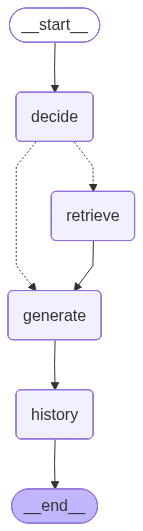

In [136]:
workflow.set_entry_point("decide")

workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve" : "retrieve",
        "generate" : "generate"
    }

)

workflow.add_edge("retrieve","generate")
workflow.add_edge("generate","history")
workflow.add_edge("history",END)

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

app

In [137]:
def ask_question_start(question:str):
    result = app.invoke(
        {"question":question,"history":[]},
        config={"configurable":{"thread_id":"news-session-1"}}
        )
    return result

In [138]:
def ask_question(question:str):
    result = app.invoke(
        {"question":question},
        config={"configurable":{"thread_id":"news-session-1"}}
        )
    return result

In [139]:
ask_question_start("Conversation is going to start...")

{'question': 'Conversation is going to start...',
 'answer': "Since the conversation is just starting, I'd like to begin by welcoming you and asking how I can assist you today. Is there something specific you'd like to talk about or ask, or would you like me to suggest some conversation topics?",
 'needs_retrieval': False,
 'history': [{'user': 'Conversation is going to start...',
   'assistant': "Since the conversation is just starting, I'd like to begin by welcoming you and asking how I can assist you today. Is there something specific you'd like to talk about or ask, or would you like me to suggest some conversation topics?"}]}

In [153]:
question = "What is the status of ashes now?"
result = ask_question(question)
answer = result

In [154]:
print(answer['answer'])

The current status of the Ashes is that England has suffered a second-Test defeat. Additionally, Ashes player ratings suggest that some players may be wilting under the pressure. England captain Stokes has stated that there is no place for weak men in his dressing room. The third Ashes Test is upcoming, and Australian captain Pat Cummins is back after being out of action since July. You can watch extended day four highlights on BBC iPlayer, and listen to the TMS podcast on BBC Sounds for more analysis and reaction.


In [155]:
print(result["needs_retrieval"])

True


In [156]:
print(result["documents"])

[Document(id='3bc68139-5ee2-4230-ad4d-3f38c2c38d8b', metadata={'source': 'https://www.bbc.com/sport', 'content_type': 'text/html', 'title': 'BBC Sport - Scores, Fixtures, News - Live Sport', 'description': 'Sports news and live sports coverage including scores, results, video, audio and analysis on Football, F1, Cricket, Rugby Union and all other UK sports.', 'language': 'en-GB'}, page_content="25 mins\nDiscover the BBC's best sports podcasts\nFootball Extra newsletter\nAll the latest news, insights and gossip from the Premier League, in your inbox every weekday.\nSign up\nThings you need to know\nMore from BBC News\nAttribution\nNews\nWhere and how to watch BBC News\nAttribution\nBBC World News: 24 hour news TV channel\nPosted\n24 February\n24 Feb\nPremier League\nEuropean Football\nFind out more about our BBC Sport app\nPosted\n16 August\n16 Aug\nFind us here\nInstagram\nTikTok\nFacebook\nX\nYouTube\nFind out more\nBBC Sport App\nHelp & FAQs\nFollow the Ashes on BBC Sport\nAdd the As